In [4]:
!pip install -q torch torchvision timm tqdm pillow kaggle


In [5]:
# Upload your kaggle.json (from your Kaggle account)
from google.colab import files
files.upload()  # choose kaggle.json when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"swethavasireddi","key":"7b7331c13fe448b2c461c6bf72f029cd"}'}

In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
!kaggle datasets download -d perke986/face-mask-segmentation-dataset
!unzip -q face-mask-segmentation-dataset.zip -d face-mask-segmentation-dataset
!ls face-mask-segmentation-dataset/images | head
!ls face-mask-segmentation-dataset/masks | head


Dataset URL: https://www.kaggle.com/datasets/perke986/face-mask-segmentation-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/78.9M [00:00<?, ?B/s]
100% 78.9M/78.9M [00:00<00:00, 1.06GB/s]
coronavirus-4947340_1920.jpg
coronavirus-5064371_1920.jpg
mask-4898571_1920.jpg
mask-5136259_1920.jpg
mouth-guard-5060809_1920.jpg
mouth-guard-5068146_1920.jpg
nurse-4962034_1920.jpg
pexels-andrea-piacquadio-3881247.jpg
pexels-anna-shvets-3902881.jpg
pexels-anna-shvets-3943881.jpg
coronavirus-4947340_1920.png
coronavirus-5064371_1920.png
mask-4898571_1920.png
mask-5136259_1920.png
mouth-guard-5060809_1920.png
mouth-guard-5068146_1920.png
nurse-4962034_1920.png
pexels-andrea-piacquadio-3881247.png
pexels-anna-shvets-3902881.png
pexels-anna-shvets-3943881.png


In [8]:
import os, torch, timm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# ---------------- Dataset ----------------
class FaceMaskSegDataset(Dataset):
    def __init__(self, root_dir, img_size=256):
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, "images")
        self.masks_dir = os.path.join(root_dir, "masks")
        self.img_names = sorted(os.listdir(self.images_dir))
        self.tf_img = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])
        self.tf_mask = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

    def __len__(self): return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path  = os.path.join(self.images_dir, name)
        mask_path = os.path.join(self.masks_dir, os.path.splitext(name)[0] + ".png")
        img  = self.tf_img(Image.open(img_path).convert("RGB"))
        mask = self.tf_mask(Image.open(mask_path).convert("L"))
        mask = (mask > 0.5).long().squeeze(0)
        return img, mask


In [9]:
# ---------------- ViT Backbone ----------------
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

class ViTExtractor(nn.Module):
    """
    Extracts intermediate features from a pretrained Vision Transformer (DINO or ViT backbone).
    We register forward hooks on the selected transformer blocks.
    """
    def __init__(self, model_name="vit_base_patch16_224", selected_layers=[2,5,8,11]):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True)
        self.selected_layers = selected_layers
        self.patch_size = self.model.patch_embed.patch_size[0]
        self.embed_dim = self.model.embed_dim
        self._features = {}

        # Register hooks to capture intermediate outputs
        for i, blk in enumerate(self.model.blocks):
            if i in selected_layers:
                blk.register_forward_hook(self._hook(i))

    def _hook(self, idx):
        def fn(_, __, output):
            self._features[idx] = output
        return fn

    def forward(self, x):
        self._features = {}
        _ = self.model.forward_features(x)
        feats = [self._features[i] for i in sorted(self._features.keys())]
        out = []
        for f in feats:
            # Remove CLS token if present
            if f.shape[1] > (x.shape[2] // self.patch_size) ** 2:
                f = f[:, 1:, :]
            out.append(f)
        return out


# ---------------- SegDINO Decoder ----------------
class SegDINO(nn.Module):
    """
    Lightweight segmentation decoder for DINO/ViT features.
    """
    def __init__(self, backbone, n_classes=2, c_out=64):
        super().__init__()
        self.backbone = backbone
        self.c_out = c_out
        self.n_classes = n_classes
        self.align = None
        self.head = None

    def _init_layers(self, n_levels, embed_dim):
        # simple linear alignment and lightweight segmentation head
        self.align = nn.ModuleList([
            nn.Sequential(nn.Linear(embed_dim, self.c_out), nn.GELU())
            for _ in range(n_levels)
        ])
        self.head = nn.Sequential(
            nn.Conv2d(n_levels * self.c_out, n_levels * self.c_out, 1),
            nn.GELU(),
            nn.Conv2d(n_levels * self.c_out, self.n_classes, 1)
        )

    def forward(self, x):
        feats = self.backbone(x)
        if self.align is None:
            self._init_layers(len(feats), self.backbone.embed_dim)
            # ✅ Ensure decoder layers move to same device as input
            self.align = self.align.to(x.device)
            self.head = self.head.to(x.device)

        maps = []
        for i, f in enumerate(feats):
            B, N, C = f.shape
            H = W = int(N ** 0.5)
            f = self.align[i](f)
            f = f.permute(0, 2, 1).reshape(B, self.c_out, H, W)
            maps.append(f)

        # Upsample and concatenate multi-scale features
        maxH = max(m.shape[-2] for m in maps)
        maxW = max(m.shape[-1] for m in maps)
        ups = [F.interpolate(m, (maxH, maxW), mode="bilinear", align_corners=False) for m in maps]
        fused = torch.cat(ups, 1)
        out = self.head(fused)
        return F.interpolate(out, size=(x.shape[-2], x.shape[-1]), mode="bilinear", align_corners=False)


In [10]:
def dice_score(pred, mask):
    pred=(pred>0.5).float(); mask=mask.float()
    inter=(pred*mask).sum(); union=pred.sum()+mask.sum()
    return (2*inter+1e-6)/(union+1e-6)

def train_one_epoch(model, loader, opt, dev):
    model.train(); ce=nn.CrossEntropyLoss(); total=0
    for imgs,masks in tqdm(loader,desc="Training"):
        imgs,masks=imgs.to(dev),masks.to(dev)
        opt.zero_grad()
        out=model(imgs)
        loss=ce(out,masks)
        loss.backward(); opt.step()
        total+=loss.item()*imgs.size(0)
    return total/len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, dev):
    model.eval(); dices=[]
    for imgs,masks in tqdm(loader,desc="Evaluating"):
        imgs,masks=imgs.to(dev),masks.to(dev)
        out=model(imgs)
        probs=torch.softmax(out,1)[:,1]
        dices.append(dice_score(probs,masks).item())
    return np.mean(dices)


In [11]:
data_root = "face-mask-segmentation-dataset"
img_size = 224    # ✅ changed
batch_size = 4
epochs = 25
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = FaceMaskSegDataset(data_root, img_size)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False)

backbone = ViTExtractor("vit_base_patch16_224", [2,5,8,11])
model = SegDINO(backbone, n_classes=2).to(device)

for p in backbone.parameters():
    p.requires_grad = False

# 🔧 Dummy input to initialize decoder
dummy = torch.randn(1, 3, img_size, img_size).to(device)
_ = model(dummy)

opt = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr)

for e in range(epochs):
    loss = train_one_epoch(model, loader, opt, device)
    dice = evaluate(model, val_loader, device)
    print(f"Epoch {e+1}/{epochs} | Loss={loss:.4f} | Dice={dice:.4f}")

torch.save(model.state_dict(), "segdino_facemask.pth")
print("✅ Training complete! Model saved as segdino_facemask.pth")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Evaluating: 100%|██████████| 222/222 [00:24<00:00,  8.97it/s]


Epoch 1/25 | Loss=0.2315 | Dice=0.0000


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.50it/s]


Epoch 2/25 | Loss=0.0513 | Dice=0.4055


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.50it/s]


Epoch 3/25 | Loss=0.0321 | Dice=0.5076


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.57it/s]


Epoch 4/25 | Loss=0.0281 | Dice=0.5457


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.55it/s]


Epoch 5/25 | Loss=0.0259 | Dice=0.5653


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.59it/s]


Epoch 6/25 | Loss=0.0242 | Dice=0.5887


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.42it/s]


Epoch 7/25 | Loss=0.0228 | Dice=0.6231


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.39it/s]


Epoch 8/25 | Loss=0.0217 | Dice=0.6259


Evaluating: 100%|██████████| 222/222 [00:22<00:00,  9.69it/s]


Epoch 9/25 | Loss=0.0206 | Dice=0.6398


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.59it/s]


Epoch 10/25 | Loss=0.0197 | Dice=0.6530


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.63it/s]


Epoch 11/25 | Loss=0.0188 | Dice=0.6732


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.62it/s]


Epoch 12/25 | Loss=0.0179 | Dice=0.6742


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.63it/s]


Epoch 13/25 | Loss=0.0171 | Dice=0.6856


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.54it/s]


Epoch 14/25 | Loss=0.0165 | Dice=0.6824


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.51it/s]


Epoch 15/25 | Loss=0.0159 | Dice=0.6972


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.50it/s]


Epoch 16/25 | Loss=0.0153 | Dice=0.7116


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.59it/s]


Epoch 17/25 | Loss=0.0150 | Dice=0.7143


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.56it/s]


Epoch 18/25 | Loss=0.0145 | Dice=0.7129


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.60it/s]


Epoch 19/25 | Loss=0.0141 | Dice=0.7146


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.49it/s]


Epoch 20/25 | Loss=0.0138 | Dice=0.7287


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.50it/s]


Epoch 21/25 | Loss=0.0135 | Dice=0.7262


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.49it/s]


Epoch 22/25 | Loss=0.0132 | Dice=0.7425


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.50it/s]


Epoch 23/25 | Loss=0.0130 | Dice=0.7328


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.49it/s]


Epoch 24/25 | Loss=0.0128 | Dice=0.7472


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.48it/s]


Epoch 25/25 | Loss=0.0126 | Dice=0.7421
✅ Training complete! Model saved as segdino_facemask.pth


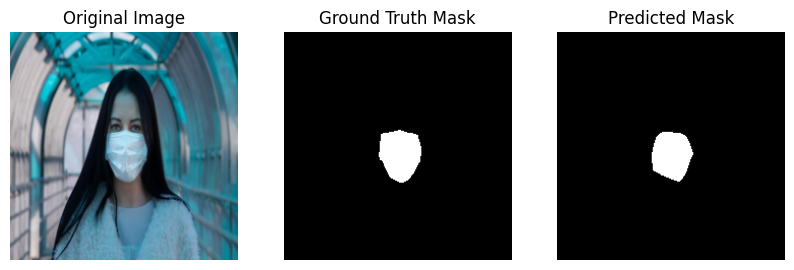

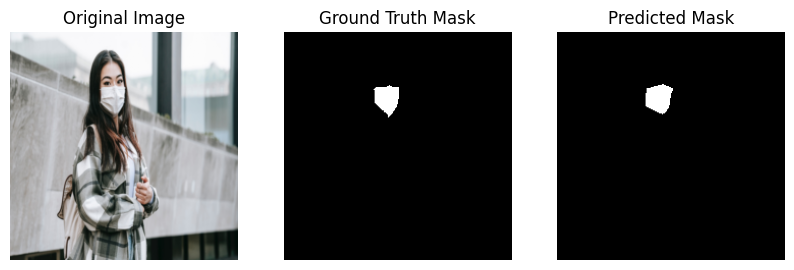

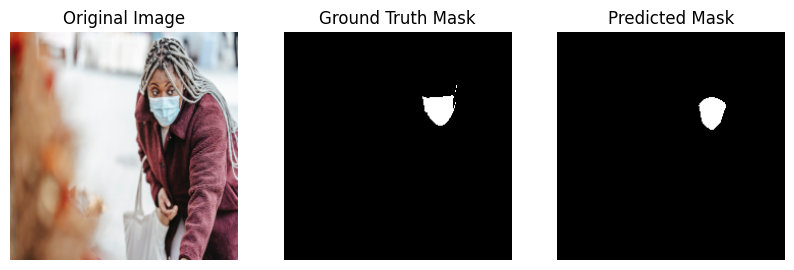

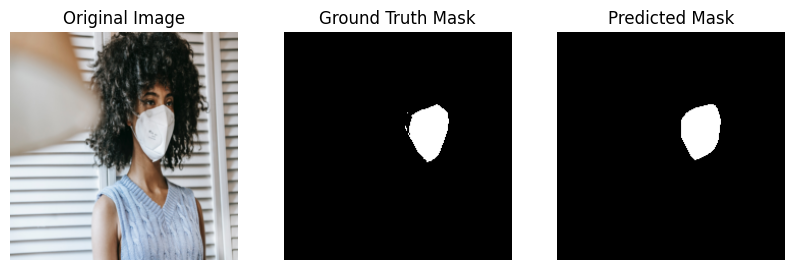

In [12]:
import matplotlib.pyplot as plt
model.eval()

# Pick some random samples
for idx in [0, 50, 120, 200]:
    img, mask = dataset[idx]
    with torch.no_grad():
        pred = torch.softmax(model(img.unsqueeze(0).to(device)), 1)[0, 1].cpu()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred > 0.5, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


In [15]:
train_losses, val_dices = [], []
best_dice = 0

for e in range(epochs):
    loss = train_one_epoch(model, loader, opt, device)
    dice = evaluate(model, val_loader, device)

    train_losses.append(loss)
    val_dices.append(dice)

    print(f"Epoch {e+1}/{epochs} | Loss={loss:.4f} | Dice={dice:.4f}")

    if dice > best_dice:
        best_dice = dice
        torch.save(model.state_dict(), "best_segdino_facemask.pth")
        print(f"✅ Best model saved (Dice={dice:.4f})")

print("🎉 Training finished successfully!")


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.44it/s]


Epoch 1/25 | Loss=0.0124 | Dice=0.7463
✅ Best model saved (Dice=0.7463)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.51it/s]


Epoch 2/25 | Loss=0.0122 | Dice=0.7435


Evaluating: 100%|██████████| 222/222 [00:24<00:00,  9.23it/s]


Epoch 3/25 | Loss=0.0120 | Dice=0.7539
✅ Best model saved (Dice=0.7539)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.43it/s]


Epoch 4/25 | Loss=0.0118 | Dice=0.7563
✅ Best model saved (Dice=0.7563)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.53it/s]


Epoch 5/25 | Loss=0.0117 | Dice=0.7447


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.48it/s]


Epoch 6/25 | Loss=0.0115 | Dice=0.7572
✅ Best model saved (Dice=0.7572)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.50it/s]


Epoch 7/25 | Loss=0.0114 | Dice=0.7588
✅ Best model saved (Dice=0.7588)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.30it/s]


Epoch 8/25 | Loss=0.0112 | Dice=0.7655
✅ Best model saved (Dice=0.7655)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.60it/s]


Epoch 9/25 | Loss=0.0111 | Dice=0.7741
✅ Best model saved (Dice=0.7741)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.55it/s]


Epoch 10/25 | Loss=0.0109 | Dice=0.7695


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.50it/s]


Epoch 11/25 | Loss=0.0108 | Dice=0.7812
✅ Best model saved (Dice=0.7812)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.57it/s]


Epoch 12/25 | Loss=0.0107 | Dice=0.7645


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.54it/s]


Epoch 13/25 | Loss=0.0106 | Dice=0.7812
✅ Best model saved (Dice=0.7812)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.58it/s]


Epoch 14/25 | Loss=0.0105 | Dice=0.7811


Evaluating: 100%|██████████| 222/222 [00:22<00:00,  9.69it/s]


Epoch 15/25 | Loss=0.0103 | Dice=0.7877
✅ Best model saved (Dice=0.7877)


Evaluating: 100%|██████████| 222/222 [00:22<00:00,  9.72it/s]


Epoch 16/25 | Loss=0.0103 | Dice=0.7950
✅ Best model saved (Dice=0.7950)


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.61it/s]


Epoch 17/25 | Loss=0.0101 | Dice=0.7823


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.55it/s]


Epoch 18/25 | Loss=0.0100 | Dice=0.7890


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.53it/s]


Epoch 19/25 | Loss=0.0100 | Dice=0.7868


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.52it/s]


Epoch 20/25 | Loss=0.0098 | Dice=0.7899


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.59it/s]


Epoch 21/25 | Loss=0.0098 | Dice=0.7926


Evaluating: 100%|██████████| 222/222 [00:23<00:00,  9.61it/s]


Epoch 22/25 | Loss=0.0097 | Dice=0.7970
✅ Best model saved (Dice=0.7970)


Evaluating: 100%|██████████| 222/222 [00:22<00:00,  9.66it/s]


Epoch 23/25 | Loss=0.0096 | Dice=0.7791


Evaluating: 100%|██████████| 222/222 [00:22<00:00,  9.66it/s]


Epoch 24/25 | Loss=0.0095 | Dice=0.8050
✅ Best model saved (Dice=0.8050)


Evaluating: 100%|██████████| 222/222 [00:22<00:00,  9.72it/s]

Epoch 25/25 | Loss=0.0094 | Dice=0.7992
🎉 Training finished successfully!


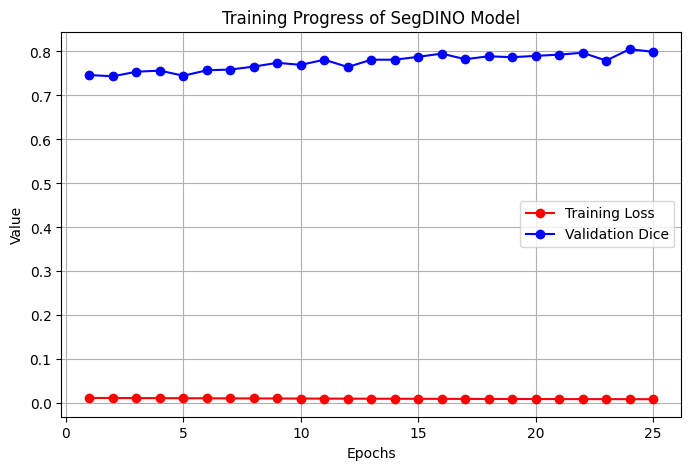

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, 'r-o', label='Training Loss')
plt.plot(range(1, len(val_dices)+1), val_dices, 'b-o', label='Validation Dice')
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Training Progress of SegDINO Model")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
from sklearn.metrics import confusion_matrix

@torch.no_grad()
def compute_metrics(model, loader, device):
    model.eval()
    ious, precs, recs, f1s = [], [], [], []
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        out = model(imgs)
        probs = torch.softmax(out, 1)[:, 1]
        preds = (probs > 0.5).float().cpu().numpy().flatten()
        gt = masks.cpu().numpy().flatten()
        tn, fp, fn, tp = confusion_matrix(gt, preds, labels=[0,1]).ravel()
        iou = tp / (tp + fp + fn + 1e-6)
        prec = tp / (tp + fp + 1e-6)
        rec = tp / (tp + fn + 1e-6)
        f1 = 2 * prec * rec / (prec + rec + 1e-6)
        ious.append(iou); precs.append(prec); recs.append(rec); f1s.append(f1)
    return {
        "IoU": np.mean(ious),
        "Precision": np.mean(precs),
        "Recall": np.mean(recs),
        "F1": np.mean(f1s)
    }

metrics = compute_metrics(model, val_loader, device)
print("📊 SegDINO Model Evaluation Metrics:")
for k,v in metrics.items():
    print(f"{k}: {v:.4f}")


📊 SegDINO Model Evaluation Metrics:
IoU: 0.7071
Precision: 0.8387
Recall: 0.7708
F1: 0.7992
